# SSP2024: Homework 2 Notebook.

# Overview

In this homework we will achieve TTS through API (in PART1); implement our own CTC loss function (in PART2) and train an end2end Speech Recognition model use CTC (PART3).

You should be able to train all models in Colab. We encourage you to read general PyTorch / Lightning tutorials as necessary as you work.

Note: You will need to make a copy of this Colab notebook in your Google Drive https://drive.google.com/drive/home before you can edit it.

## Deadline: 2024.12.31 24:00

You have 3 days late policy. Any submissions within three days of the deadline can still be accepted but with penalty. Submission after three days of the deadline will not be accepted and marked as zero. 

# Part 1: Generating Synthetic Voices (30 points)

In [2]:
# !pip install "openai~=1.14.1" "transformers~=4.39.1" "librosa~=0.10.1" "matplotlib~=3.7.1"

In [3]:
import librosa
import librosa.display
import librosa.effects
import librosa.util

import numpy as np
import matplotlib.pyplot as plt

# used to play audio files
import IPython.display as ipd
from base64 import b64decode

In [4]:
# helper function to plot a mel spectrogram
# arguments: (wave array, sampling rate, number of mel bins, max frequency of mel scale)
def plot_melspectrogram(wav, sr, annotations=None, n_mels=256, fmax=4096,
                        fig=None, ax=None, show_legend=True):

    if ax == None:
      fig, ax = plt.subplots(1,1,figsize=(20,5))
    M = librosa.feature.melspectrogram(y=wav, sr=sr, n_mels=n_mels, fmax=fmax, n_fft=2048)
    M_db = librosa.power_to_db(M, ref=np.max)
    img = librosa.display.specshow(M_db, y_axis='mel', x_axis='time', ax=ax, fmax=fmax)
    if show_legend:
      ax.set(title='Mel spectrogram display')
      fig.colorbar(img, ax=ax, format="%+2.f dB")

    # iterate over list of text annotations and draw them
    if annotations is not None:
        for x,y,text in annotations:
            ax.annotate(
            text,
            xy=(x,y), xycoords='data',
            xytext=(10, -50), textcoords='offset pixels',
            horizontalalignment='right',
            color='white',
            fontsize=20,
            verticalalignment='bottom',
            arrowprops=dict(
                arrowstyle= '-|>',
                 color='white',
                 lw=1,
                 ls='-')
            )

## Using a Text-to-Speech API (**LMNT**)

1. Create a free account on [app.lmnt.com](https://app.lmnt.com) and create an API key [here](https://app.lmnt.com/account).
2. Add the API key to your Colab Environment secrets on the left menu and enable notebook access.

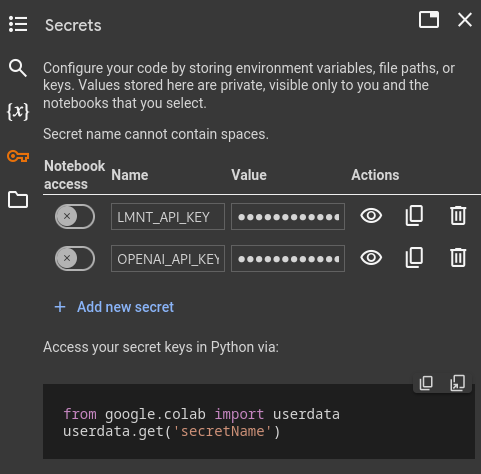



In [5]:
# Install the lmnt sdk
# !pip install lmnt

In [6]:
from google.colab import userdata
LMNT_API_KEY = userdata.get("LMNT_API_KEY")


assert LMNT_API_KEY is not None and LMNT_API_KEY != ""

In [ ]:
# Let's choose a voice to use from the API
from pprint import pprint
from lmnt.api import Speech

async with Speech(api_key=LMNT_API_KEY) as speech:
    voices = await speech.list_voices()
    pprint(voices)

In [ ]:
from IPython.display import Audio, display
from scipy.io import wavfile
import io
import librosa
import numpy as np

# for this example, we will try Eleanor's voice. Feel free to modify this.
voice = next((v for v in voices if v["name"] == "Chloe"))

async with Speech(LMNT_API_KEY) as speech:
    response = await speech.synthesize(
        text="Back in my day, I had to walk to school uphill... both ways.",
        voice=voice["id"],
        format="wav"
    )

lmnt_audio_response = response["audio"]

fd = io.BytesIO(lmnt_audio_response)
lmnt_sr, lmnt_data = wavfile.read(fd)

# librosa only accepts f32s
lmnt_audio = lmnt_data.astype(np.float32)


# plot the audio
fig, ax = plt.subplots(2,1,figsize=(20,15))
plot_melspectrogram(lmnt_audio, lmnt_sr, fig=fig, ax=ax[0])
librosa.display.waveshow(lmnt_audio, sr=lmnt_sr, ax=ax[1])

Audio(lmnt_audio, rate=lmnt_sr)

### **Task 1: Listening test and Mean Opinion Score (MOS)** (5 points)

Human evaluations are often the best metric for TTS systems since it's difficult to automate evaluation of subtle voice features.

Generate 5 utterances using LMNT, you may choose what transcripts to use, and try to create a range of difficulties including pronunciation or emotive utterances.

For each utterance, listen to it (ideally with decent headphones/speakers) and provide a score of 1-5 (1 worst, 5 best) for each of these four categories:
- Naturalness: How natural/human does the audio sound in terms of voice quality?
- Intelligibility: Is the audio comprehensible and easy for you to understand the first time you hear it?
- Expressiveness: Is the audio expressive and does prosody/tone match what you would expect a human to express when saying the same thing?
- Overall: Your overall opinion on the quality of this TTS

Compute and report your _mean opinion score_ for each category by averaging across the five utterances.

In [ ]:
# Hard code your opinion scores for each of the five utterances here
# Compute and display your mean opinion score for each category
from statistics import mean

voice = next((v for v in voices if v["name"] == "Ava"))

utterances = [
    "The quick brown fox jumps over the lazy dog.",
    "Do you know where the nearest coffee shop is?",
    "I can't believe it's already Friday!",
    "She sells seashells by the seashore.",
    "To be, or not to be, that is the question."
]

async with Speech(LMNT_API_KEY) as speech:
    for text in utterances:
        response = await speech.synthesize(
            text=text,
            voice=voice["id"],
            format="wav"
        )

        lmnt_audio_response = response["audio"]

        fd = io.BytesIO(lmnt_audio_response)
        lmnt_sr, lmnt_data = wavfile.read(fd)

        lmnt_audio = lmnt_data.astype(np.float32)
        display(Audio(lmnt_audio, rate=lmnt_sr))

#############################
#### YOUR CODE GOES HERE ####
# for four categories: natrualness, intelligibility expressiveness overall
naturalness = [4, 3, 2, 4, 3]
intelligibility = [5, 4, 4, 4, 4]
expressiveness = [4, 2, 2, 4, 3]
overall_opinion = [mean([ni, ii, ei]) for ni, ii, ei in zip(naturalness, intelligibility, expressiveness)]

mean_naturalness = np.mean(naturalness)
mean_intelligibility = np.mean(intelligibility)
mean_expressiveness = np.mean(expressiveness)
mean_overall_opinion = np.mean(overall_opinion)
print("Mean Naturalness: ", mean_naturalness)
print("Mean Intelligibility: ", mean_intelligibility)
print("Mean Expressiveness: ", mean_expressiveness)
print("Mean Overall Opinion: ", mean_overall_opinion)

#############################


MOS is a useful metric for TTS, but often times the best way to elicit human feedback is via a _forced choice A/B comparison_. That means presenting two options and asking the human evaluator which they prefer in terms of naturalness, expressiveness, etc.

### **Task 2: A/B comparison evaluation of Rime and LMNT** (5 points)

Generate five utterances using the landing page demo on [rime.ai](https://rime.ai/). Using LMNT generate a matching set of five utterances (same transcript). You many choose what voice and settings to use for both. (Making an A/B comparison between the TTS results of RIME and LMNT.)

For each of the five utterances. Pick which system you prefer in terms of:
- Naturalness: How natural/human does the audio sound in terms of voice quality?
- Intelligibility: Is the audio comprehensible and easy for you to understand the first time you hear it?
- Expressiveness: Is the audio expressive and does prosody/tone match what you would expect a human to express when saying the same thing?
- Overall: Your overall opinion on the quality of this TTS

Report the aggregated comparison scores across your five utterances for each category. Finally, make a final recommendation of which system to use in a video game -- your final assessment can include factors related to the variation of available voices, their emotional range, etc.


```
Your response here
```
utterances Evaluated:

Utterance 1: RIME.ai Clear and neutral

Utterance 2: RIME.ai Expressive and neutral. 

Utterance 3: RIME.ai Expressive.

Utterance 4: LMNT slurred pronunciation

Utterance 5: Both are ok.

Based on the evaluation of RIME.ai and LMNT, RIME.ai produces higher scores for naturalness, expressiveness, and overall quality.
RIME.ai is particularly good for creating more natural-sounding voices with varied emotional ranges, making it more suitable for use in video games, where voice expressiveness plays a significant role in enhancing the player's experience.

## Voice Cloning


### **Task 3: Clone your voice** (5 points)

Now let's use LMNT to create a clone of your voice using a small amount of audio from you speaking.

NOTE: As always, we strongly encourage anyone to obtain explicit consent from someone before cloning their voice. Yes, it's fun to clone your friends' voices -- but get permission first.

Helper function to record your own audio. You'll need to grant microphone access in your browser and have a working microphone for this to work

In [10]:
# RECORD = """
# const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
# const b2text = blob => new Promise(resolve => {
#   const reader = new FileReader()
#   reader.onloadend = e => resolve(e.srcElement.result)
#   reader.readAsDataURL(blob)
# })
# var record = time => new Promise(async resolve => {
#   stream = await navigator.mediaDevices.getUserMedia({ audio: true })
#   recorder = new MediaRecorder(stream)
#   chunks = []
#   recorder.ondataavailable = e => chunks.push(e.data)
#   recorder.start()
#   await sleep(time)
#   recorder.onstop = async ()=>{
#     blob = new Blob(chunks)
#     text = await b2text(blob)
#     resolve(text)
#   }
#   recorder.stop()
# })
# """

# def record(sec=5):
#   try:
#     from google.colab import output
#   except ImportError:
#     print('No possible to import output from google.colab')
#     return ''
#   else:
#     print('Recording')
#     display(ipd.Javascript(RECORD))
#     s = output.eval_js('record(%d)' % (sec*1000))
#     fname = 'recorded_audio.wav'
#     print('Saving to', fname)
#     b = b64decode(s.split(',')[1])
#     with open(fname, 'wb') as f:
#       f.write(b)
#     return fname

In [11]:
# record about 5 minutes of your voice
# If you don't know what to talk about, pick a post off of hackernews and read
# Try to record in a quiet room, and continue talking the entire time
# record(300)

In [ ]:
file_path = "trimmed_audio_300s.wav"  # 替换为你的音频文件路径
y, sr = librosa.load(file_path, sr=None)
Audio(y, rate=sr)

In [13]:
# !mv recorded_audio.wav train_audio.ogg
# !ffmpeg -y -i ./train_audio.ogg train_audio.wav

In [ ]:
# Create the new voice (this will take 30 minutes or longer)
async with Speech(LMNT_API_KEY) as speech:
  res = await speech.create_voice(
      "my-new-voice-2",
      enhance=False,
      filenames=[file_path]  # note: This pulls from the filesystem.
  )

pprint(res)
my_model_id = res["id"]

check if your voice have been uploaded here. https://app.lmnt.com/voice-library

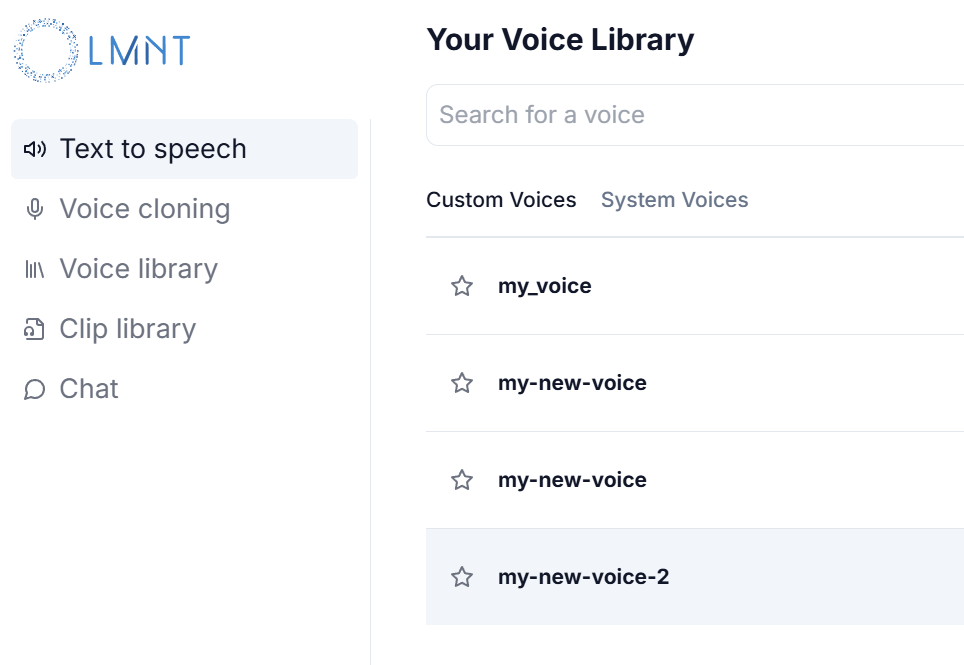

In [ ]:
# run this after 20 minutes to check the status of your new model. It should be at the top.
async with Speech(LMNT_API_KEY) as speech:
  v = await speech.list_voices()
  pprint(v)

In [ ]:
from pprint import pprint
from IPython.display import Audio
async with Speech(LMNT_API_KEY) as speech:
  # res = await speech.synthesize("Oh my god I hate python", model_id)
  res = await speech.synthesize("This is pretty cool. There are some noticeable artifacts in the audio but it sounds like me!", my_model_id, format="wav")

audio_bytes = res["audio"]

Audio(audio_bytes)

Now let's visualize the audio with waveshow and a melspectrogram.

In [ ]:
fd = io.BytesIO(audio_bytes)
clone_sr, clone_data = wavfile.read(fd)

# librosa only accepts f32s
clone_audio = clone_data.astype(np.float32)


fig, ax = plt.subplots(2,1,figsize=(20,10))
plot_melspectrogram(clone_audio, clone_sr, annotations=None, n_mels=256,
                    fmax=4096, fig=fig, ax=ax[0], show_legend=False)
librosa.display.waveshow(clone_audio, sr=clone_sr, ax=ax[1])

Comment on your impressions of the voice clone. Describe differences you hear between the clone and your actual voice. Do you think this quality of clone could convince someone it's actually you?

```
(I heard a voice in the IPython file that doesn't sound like mine, but the one I heard on the official website's model sounds)
Very much like me! Especially when I speak slowly and with some accent habits, etc. However, sometimes the timbre doesn't quite match. The intonation is a bit different, and sometimes the emphasis is slightly off.
I think the quality will convince someone who is not farmiliar with me.
```

### **Task4: Finding markers of non-human speech in visualizations** (5 points)

One way we might reveal that an utterance is from a TTS system rather than real human voice is via visualizing the time-domain and spectrogram plots to find indicators of TTS.

Using an utterance from your voice clone, visualize both the time domain and spectrogram to show any indicators the voice is not human. Adjust your plots by zooming in or anything else you choose.

Describe any indicators you can find that would support a claim that the voice clone utterance does not come from a human. It might help to compare with human-produced utterances from above.

In [ ]:
# Visualize an utterance with both spectrogram and time domain.
# Adjust your plots to show indicators this comes from TTS

#############################
#### YOUR CODE GOES HERE ####

voice = next((v for v in voices if v["name"] == "Ava"))

utterance = "The quick brown fox jumps over the lazy dog."

async with Speech(LMNT_API_KEY) as speech:
    response = await speech.synthesize(
        text=utterance,
        voice=voice["id"],
        format="wav"
    )

    lmnt_audio_response = response["audio"]

    fd = io.BytesIO(lmnt_audio_response)
    human_sr, human_data = wavfile.read(fd)

    human_audio = human_data.astype(np.float32)

# human result
fig, ax = plt.subplots(2,1,figsize=(20,10))
plot_melspectrogram(human_audio, clone_sr, annotations=None, n_mels=256,
                    fmax=4096, fig=fig, ax=ax[0], show_legend=False)
librosa.display.waveshow(human_audio, sr=clone_sr, ax=ax[1])

# clone result
async with Speech(LMNT_API_KEY) as speech:
  # res = await speech.synthesize("Oh my god I hate python", model_id)
  res = await speech.synthesize(utterance, my_model_id, format="wav")
  audio_bytes = res["audio"]

fd = io.BytesIO(audio_bytes)
clone_sr, clone_data = wavfile.read(fd)

# librosa only accepts f32s
clone_audio = clone_data.astype(np.float32)

fig, ax = plt.subplots(2,1,figsize=(20,10))
plot_melspectrogram(clone_audio, clone_sr, annotations=None, n_mels=256,
                    fmax=4096, fig=fig, ax=ax[0], show_legend=False)
librosa.display.waveshow(clone_audio, sr=clone_sr, ax=ax[1])


#############################

Describe your findings. What indicators can you find in the visualizations corresponding to non-human speech?


```
Waveform Regularity: TTS systems often produce audio with more regular and less varied waveforms compared to human voices which are typically more irregular and dynamic.

Breath Sounds: Human recordings often include breathing sounds which are usually absent in TTS-generated audio.
```

## Using Bark

[Bark](https://github.com/suno-ai/bark) is a transformer-based model for generating audio from a text prompt. It's broader than just generating speech, it can generate non-speech noises including environmental sounds or signing. Bark is broad, but it is sometimes difficult to control -- the model may deviate from the prompt.

Let's generate some audio with Bark and compare it with our other TTS systems so far.



Before continuing, ensure the notebook runtime is set to T4 GPU

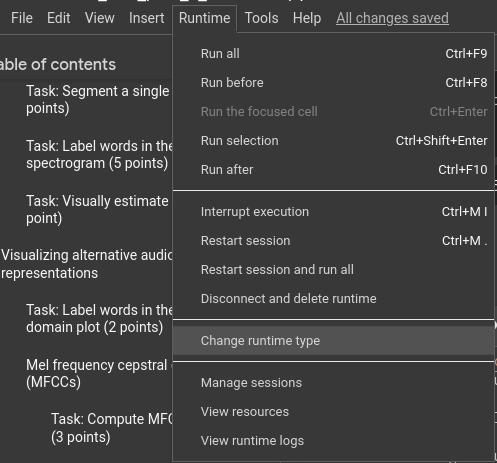

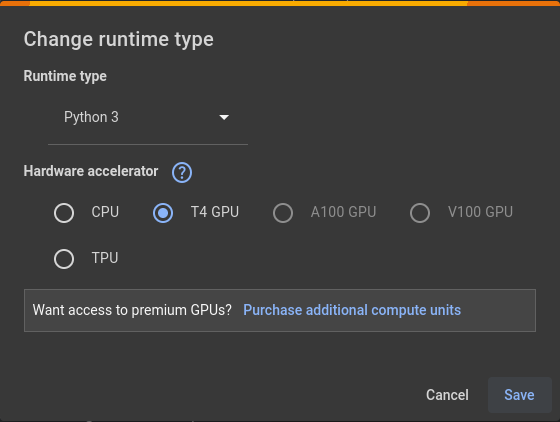

In [ ]:
from transformers import AutoProcessor, BarkModel
processor = AutoProcessor.from_pretrained("suno/bark")
model = BarkModel.from_pretrained("suno/bark").to("cuda")
model.cuda()

voice_preset = "v2/en_speaker_6"


In [ ]:
inputs = processor("Back in my day, I had to walk to school uphill... both ways", voice_preset=voice_preset).to("cuda")

bark_audio_array = model.generate(**inputs)
bark_audio_array = bark_audio_array.cpu().numpy().squeeze()
bark_sr = model.generation_config.sample_rate

# plot the audio
fig, ax = plt.subplots(2,1,figsize=(20,15))
plot_melspectrogram(bark_audio_array, bark_sr, fig=fig, ax=ax[0])
librosa.display.waveshow(bark_audio_array, sr=bark_sr, ax=ax[1])

Audio(data=bark_audio_array, rate=bark_sr)

### **Task 5: Compare to normal TTS systems** (5 points)

Use Bark to generate utterances with the same transcript as some of your LMNT or Rime utterances. Visualize the Bark samples you generate as a spectrogram.

Comment on Bark vs traditional TTS approaches. Does Bark sound better as a TTS system in terms of naturalness? Expressiveness? Does Bark always remain faithful to the input transcript? You do not need to perform a full listening test comparison.


In [ ]:
# Generate at least 1 sample for Bark. Visualize the utterance in a spectrogram
# Comment on Bark vs TTS systems from above

#############################
#### YOUR CODE GOES HERE ####



#############################

### **Task 6: Generate audio that a normal TTS can't produce** (5 points)

Bark can do much more than a standard TTS system. Think of an application where you might want a mix of speech and other sounds, or heavily modified prosody. Generate at least one sample with Bark that a normal TTS system would not produce, and describe how Bark might support the application / use case you picked.

In [ ]:
# Generate at least 1 sample for Bark. Visualize the utterance in a spectrogram
# Comment on applications where you might prefer Bark over traditional TTS

#############################
#### YOUR CODE GOES HERE ####


#############################

# Part 2: CTC Loss Implementation (30 points)

We introduce the Connectionist Temporal Classification (CTC) objective, which is a popular objective used to train neural networks to do speech recognition. Critically, it does not require you to know the alignments between inputs and outputs.

## Summary of CTC

We highlight some of the main features of the CTC objective.

- Given a sequence of inputs `x_1, x_2, .., x_T`, an ASR model will map each of these to a probability of an alphabet of C tokens: `p_1, p_2, ..., p_T`. For example, if we are decoding to three possible characters, the probabilities for timestep `t` could look like `p_t = [0.3, 0.2, 0.5]`.

- We also have a sequence of symbol targets `y_1, y_2, ..., y_S` (note `S <= T`). Each `y_s` is a number from `0` to `C-1` (e.g. one of the characters).

- The main strategy is to decode each `x_t` to a predicted character `y'_t`. For example, `x_1, x_2, ..., x_6 -> c c a a a t`. This mapping is called an **alignment**. Then we can collapse repetitions to get `c a t` as the predicted output sequence. This simple strategy has some problems: how do you handle silences or repeated characters?

- CTC adds a special `blank` token. We'll call this `eps`. Now consider this example, `x_1, x_2, ..., x_12 -> h h e eps eps l l l eps l l o`. Now we can collapse everything in between each `eps` to get `h e eps l eps l o`. Removing blank tokens, we get the prediction `hello`.

- For an output sequence, there are many "valid" alignments. For example, given an input sequence `x_1, ..., x_6` and an output sequence `c a t`, valid alignments include `eps c c eps a t`, `c c a a t t`, or `c a eps eps eps t`. Example of invalid alignments include `c eps c eps a t`, `c c a a t` (too short if the input sequence has 6 tokens), and `c eps eps eps t t`.

- Let `A` represent all valid alignments of an output sequence to an input sequence. A simplified pseudocode for the CTC objective might look like:

```
all_log_prob = 0

for each (a_1, a_2, ..., a_S) in A:

    log_prob = 0

    for t in 1 to T:
        # The alignment a_s has a specific output character for input position t
        log_prob_t = log p(a_(s,t) | x_1, ..., x_T)
        # compute the joint probability by multiplying independent time steps
        # Adding in log space to avoid underflow
        log_prob += log_prob_t

    all_log_prob += log_prob
```
That is, the CTC loss computes the probability of all possible alignments. Please note that the pseudocode above is for intuition. In practice, it is often too slow to enumerate over `A` explicitly.

As an example, for an output sequence of length 50 (without any repeated characters) and an input sequence of length 100, the number of unique alignments is almost 10^40.

#### **Dynamic Programming in CTC**

In class, we introduced the "forward algorithm" to tractably compute likelihoods for HMMs. We can do something similar to score alignments more efficiently than manually enumerating over the full set.

In other words, we can do dynamic programming. Since many alignments share partial sub-sequences, we can  store the `log_prob` for all sub-sequences we have seen so far. This allows us to reuse computation when computing the likelihood for a new sequence.

The logic is as follows:

Recall `X` is the input sequence of maximum length `T` and `Y` is the output sequence of maximum length `S`. Build a new sequence `Z` that adds a blank token between every character.

```
Y = [y_1, y_2, ..., y_S]
Z = [eps, y_1, eps, y_2, ..., eps, y_S, eps]
  = [z_1, z_2, z_3, z_4, ..., z_2S-1, z_2S, z_2S+1]
```
Note that the length of `Z` is now `2S+1`.

**Step 1: Make a Cache.**

Instantiate a matrix of size `T x (2S+1)`. Call this matrix `C`. The index `C[t][s]` represents a probability score for the subsequence `z_1, ..., z_s` after observing `x_1, ..., x_t`. That is, `C[t][s] = p(y_1, ..., y_s/2 | x_1, ..., x_t)`.

**Step 2: Make an Update Rule.**

The goal of dynamic programming is to reuse `C[t-1]` in computing `C[t]`. To do that, we need to define an update rule. There are two cases depending on what  the token `z_s` is.

- <ins>Case 1</ins>: `z_s` is a blank token OR `z_s = z_s-2`. This is the standard forward algorithm update. We build `p(z_1, ..., z_s|x_1, ..., x_t)` using two parts: `p(z_1, ..., z_s|x_1, ..., x_t-1)` and `p(z_1, ..., z_s-1|x_1, ..., x_t-1)`. Assuming an increasing order of `t` and `s`, these two parts will already have been computed. (If `s = 0` you can ignore the `C[t-1][s-1]` term. If `t = 0`, set `C[t][s] = p(z_s | x_1, ..., x_t)`.)
```
C[t][s] = (C[t-1][s-1] + C[t-1][s]) * p(z_s | x_1, ..., x_t)
```
In other words, `C[t-1][s-1]` and `C[t-1][s]` are known. The prediction for `p(z_s | x_1, ..., x_t)` is known (e.g. `log_probs`).

- <ins>Case 2</ins>: `z_s` is not a blank token AND `z_s != z_s-2`. The tricky part is to notice that `z_s-1` is a blank token. Since our Markov assumption says `y_t` should depend on `y_t-1`, which means `z_s` should depend on both `z_s-1` and `z_s-2` (since we artificially added `z_s-1`). Similarly, ignore terms that do not exist.
```
C[t][s] = (C[t-1][s-2] + C[t-1][s-1] + C[t-1][s]) * p(z_s | x_1, ..., x_t)
```

Now, we still need two for loops to loop over `1 ... T` and `1 ... S` but this is usually much cheaper than looping over alignments.

```
C = init_cache(T, S)
for t in 1 to T:
  for s in 1 to 2S+1:
    C = do_update(t, s, C)

p_y_given_x = C[-1][-1] + C[-1][-2]  # sum the probability of the last epsilon and last non-epsilon tokens
```

For more information, refer to this [blog](https://distill.pub/2017/ctc/) or the original [paper](https://www.cs.toronto.edu/~graves/icml_2006.pdf) by Alex Graves.



Please write a function in PyTorch that given a minibatch of model predicted probabilities and a minibatch of output sequences, computes the CTC objective.

**Note:** You cannot use the built-in `F.ctc_loss` in PyTorch.



**Deliverable:** Code that calculates the CTC loss and passes the sanity-check.

In [ ]:
import torch
import torch.nn.functional as F

def ctc_loss(
    log_probs: torch.FloatTensor, targets: torch.LongTensor,
    input_lengths: torch.LongTensor, target_lengths: torch.LongTensor,
    blank: int = 0) -> torch.Tensor:
  """Connectionist Temporal Classification implementation.

  Args:
    log_probs: The log-beliefs returned by an ASR model.
      This is `log p(a_t | x_1, ..., x_T)`.
      (Shape: T x batch_size x C, where T is a maximum input sequence length and
      C is the alphabet size (including blank))

    targets: Sequence of contiguous output labels (no blanks).
      This is `y_1, ..., y_S`.
      (Shape: batch_size x S, where S is a maximum output sequence length)

    input_lengths: Lengths of each example in minibatch (<= T).
      (Shape: batch_size)

    target_lengths: Lengths of each target in minibatch (<= S).
      (Shape: batch_size)

    blank: The "epsilon" token that is used to represent silence.
      (integer <= C, default 0)

  Returns:
    CTC loss averaged over minibatch.
  """
  #############################
  #### YOUR CODE GOES HERE ####


  #############################

Here is a good sanity check. Test you code by checking below that `test` and `soln` are roughly equal. It's okay if your solution is much slower since the Pytorch one is coded in C. However, we will deduct points if you enumerate over all alignments as this is too slow for practical use.


In [ ]:
log_probs = torch.randn(50, 16, 20).log_softmax(2).detach().requires_grad_()
targets = torch.randint(1, 20, (16, 30), dtype=torch.long)
input_lengths = torch.full((16,), 50, dtype=torch.long)
target_lengths = torch.randint(10,30,(16,), dtype=torch.long)

est = ctc_loss(log_probs, targets, input_lengths, target_lengths, blank=0)
soln = torch.mean(F.ctc_loss(log_probs, targets, input_lengths, target_lengths, blank=0, reduction='none'))

print(est.detach().numpy(), soln.detach().numpy())

### Task 7: Implement CTC on your own and demonstrate your implementation (30 points)

Print your loss function results on the log_probs and targets we provide. You can load the test minibatches by calling `get_test_minibatches()`.

In [ ]:
import numpy as np
import random

def get_test_minibatches() -> list:
  """Get minibatches to test implementation
  Returns:
    lists of log_probs, targets, input_lengths, target_lengths
  """
  torch.manual_seed(224)
  np.random.seed(224)
  random.seed(224)

  T = np.array([])
  C = np.array([])
  N = np.array([])
  S = 40  # Target sequence length of longest target in batch (padding length)
  for i in range(10):
    T = np.append(T, random.randint(i+50, i+80))
    C = np.append(C, random.randint(int(0.4* T[i]), int(0.8*T[i])))
    N = np.append(N, random.randint(int(0.7 *C[i]), int(0.9*C[i])))

  log_probs = []
  input_lengths = []
  target_lengths = [] # 10 x N[i]
  targets = []
  for i in range(10):
    log_probs.append(torch.randn(int(T[i]), int(N[i]), int(C[i])).log_softmax(2).detach().requires_grad_())
    input_lengths.append(torch.full((int(N[i]),), fill_value = int(T[i]), dtype=torch.long))
    target_lengths.append(torch.randint(low = 1,high = S, size = (int(N[i]),), dtype=torch.long))
    targets.append(torch.randint(low = 1, high = int(C[i]), size = (int(N[i]), S), dtype=torch.long))

  return log_probs, targets, input_lengths, target_lengths

In [ ]:
log_probs, targets, input_lengths, target_lengths = get_test_minibatches()

In [ ]:
for i in range(len(log_probs)):
  print(i, ctc_loss(log_probs[i], targets[i], input_lengths[i], target_lengths[i], blank=0).detach().numpy(),
        torch.mean(F.ctc_loss(log_probs[i], targets[i], input_lengths[i], target_lengths[i], blank=0, reduction='none')).detach().numpy())

# Part 3: End-to-End Speech Recognition (50 points)

In [ ]:
#@title Setup Cell

#@markdown **Mount Google Drive.** We will use your `ssp2024_floder`
#@markdown directory in your Google Drive to store all relevant files,
#@markdown including `utils.py`.

# Do not modify.

import os
from google.colab import drive
drive.mount('/content/gdrive')

DRIVE_PATH = '/content/gdrive/My\ Drive/ssp2024_floder'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
if not os.path.exists(DRIVE_PYTHON_PATH):
  %mkdir $DRIVE_PATH

SYM_PATH = '/content/ssp2024_floder'
if not os.path.exists(SYM_PATH):
  !ln -s $DRIVE_PATH $SYM_PATH

#@markdown **Data.** It takes ~5-10 minutes to download the dataset the first
#@markdown time you run this cell. Afterwards it will stay saved in
#@markdown `ssp2024_floder/data/harper_valley_bank_minified`.


DATA_PATH = '{}/data'.format(SYM_PATH)
if not os.path.exists(DATA_PATH):
  %mkdir $DATA_PATH
%cd $DATA_PATH
if not os.path.exists(os.path.join(DATA_PATH, 'harper_valley_bank_minified')):
  !wget -q http://web.stanford.edu/class/cs224s/download/harper_valley_bank_minified.zip
  !unzip -q harper_valley_bank_minified.zip
  %rm harper_valley_bank_minified.zip

#@markdown **Experiments.** Model checkpoints will be saved in your
#@markdown `ssp2024_floder/trained_models` directory.
MODEL_PATH = '{}/trained_models'.format(SYM_PATH)
if not os.path.exists(MODEL_PATH):
  %mkdir $MODEL_PATH

#@markdown **Note on Sessions.** You have to run this cell each new session
#@markdown (sessions either expire after some time or after you close the notebook).
#@markdown You may have to periodically go to **Runtime** > **Factory reset runtime**
#@markdown if you are experiencing Colab environment issues. Requirements must be installed each new session.

!pip -q install pytorch_lightning==1.9.3
!pip install wandb -qqq

from collections import OrderedDict
from itertools import chain

import h5py
import math
import json
import torch
import wandb
import numpy as np
import pytorch_lightning as pl
from glob import glob
import librosa
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import random
from sklearn.metrics import f1_score
from typing import *
from IPython.display import Audio
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger


## 3.1: ML Speech Data Pipeline

HarperValleyBank consists of 23 hours of audio from 1,446 human-human conversations between 59 unique speakers. For your convenience, we store in `harper_valley_bank_minified` all utterance audio waveforms as `numpy` arrays in `data.h5` and all transcripts and labels as `numpy` arrays in `labels.npz`.

Our custom dataset class `HarperValleyBank` should inherit `torch.utils.data.Dataset` and overwrite the following methods:
- `__len__` so that `len(dataset)` returns the size of the dataset.
- `__getitem__` to support the indexing such that `dataset[i]` can be used to get the `i`th dataset sample.

There are a few special features that the `HarperValleyBank` class should exhibit.
- **Fixed-length data.** Both the extracted audio features and the character labels will inherently be sequences of different lengths. However, in order to store data in a minibatch during training, we need to make the lengths uniform. To do so, we can first enforce a maximum length for audio waves and a maximum length for labels (note that these two maximum lengths are not necessarily the same). We have preprocessed all sequences to be cropped by single utterances as opposed to conversations. Next, we can crop and pad each sequence with a pad token (e.g. `3`) such that all audio sequences and all label sequences are their respective maximum lengths. We will also store the actual lengths of each sequence so that the model does not learn from the padded indices.
- **Sequence representation.** We are training a character-level model, so the ASR model is responsible for predicting each spoken character. Therefore, we must convert our transcript text to a list of indices representing 34 possible characters (see the global variable `VOCAB`) and a few domain-specific tokens (see the global variable `SILENT_VOCAB` e.g. `[laughter]`). Think of each character as its own class.
```
Raw utterance:  hi this is an example .
List of characters: ['h', 'i', ' ', 't', 'h', 'i', 's', ' ', 'i', 's', ' ', 'a', 'n', ' ', 'e', 'x', 'a', 'm', 'p', 'l', 'e', ' ', '.']
List of indices: [18, 19, 3, 30, 18, 19, 29, 3, 19, 29, 3, 11, 24, 3, 15, 34, 11, 23, 26, 22, 15, 3, 6]
```
- **Special tokens.** Although this next part is provided, it is worth pointing out. Aside from the padding index, there are three special tokens in our vocabulary:
    - A blank token (`epsilon`, represented by index `0`) which designates a padded index and plays a special role in CTC.
    - A start-of-sentence token (`SOS`, represented by index `1`) which designates the start of a sentence.
    - An end-of-sentence token (`EOS`, represented by index `2`) which designates the end of a sentence.
```
Example label sequence: [18, 19, 3, 30, 18]
Add an END token: [18, 19, 3, 30, 18, 2]
```
Suppose the maximum label sequence has length 10.
```
Padded label sequence: [18, 19, 3, 30, 18, 2, 0, 0, 0, 0]
Label sequence length: 6
```

**It may be helpful to first read through the `HarperValleyBank` starter code and `utils.py` to get familiar with the data pipeline.**

Below, we provide a cell for you to index into the raw data and listen to randomly chosen samples.

In [ ]:
root = os.path.join(DATA_PATH, 'harper_valley_bank_minified')
waveform_h5 = h5py.File(os.path.join(root, 'data.h5'), 'r')
waveform_data = waveform_h5.get('waveforms')
label_data = np.load(os.path.join(root, 'labels.npz'))
assert len(waveform_data) == len(label_data['human_transcripts'])
index = random.randint(0, len(waveform_data) - 1)
w = waveform_data[f'{index}'][:]
t = label_data['human_transcripts'][index]

print('index {}: "{}"\n'.format(index, t))
Audio(w, rate=8000)

### **Task 8: Set up primary task data (5 Points)**

**Implementation**

Notice that the `__getitem__` returns 4 objects:
- `inputs`: the padded log-Mel spectrogram features.
- `input_lengths`: the true length of the unpadded spectrogram features.
- `labels`: the padded character labels.
- `label_lengths`: the true length of the unpadded character labels.

These objects will be used for what we call our *primary* task: speech recognition. In later parts, we will use *auxiliary* tasks to perform multi-task learning toward boosting speech recognition.

**→ Implement the `get_primary_task_data` method.** This will be used in the `__getitem__` method of `HarperValleyBank` and later its subclass for multi-task learning, and it is responsible for extracting log-Mel spectrogram features from the raw audio clips. Do not modify other methods. You should pass the sanity check at the end.


Drag the utils.py in the google drive (under the same floder)

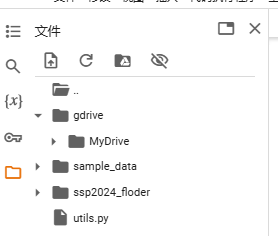

In [ ]:
from utils import (
  prune_transcripts, pad_wav, pad_transcript_label, get_transcript_labels,
  get_cer_per_sample)


# HarperValleyBank character vocabulary
VOCAB = [' ', "'", '~', '-', '.', '<', '>', '[', ']', 'a', 'b', 'c', 'd', 'e',
         'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's',
         't', 'u', 'v', 'w', 'x', 'y', 'z']

SILENT_VOCAB = ['[baby]', '[ringing]', '[laughter]', '[kids]', '[music]',
                '[noise]', '[unintelligible]', '[dogs]', '[cough]']


class HarperValleyBank(Dataset):
  """Dataset to be used to train CTC, LAS, and MTL.

  Args:
    root: string
          path to the data files.
    split: string (default: train)
            choices: train | val | test
            which split of data to load
    n_mels: integer (default: 128)
            number of mel frequencies
    n_fft: integer (default: 256)
            number of fourier components
    win_length: integer (default: 256)
                should be <= n_fft
    hop_length: integer (default: 128)
                number of frames to skip in between
    wav_max_length: integer (default: 200)
                    maximum number of timesteps in a waveform
    transcript_max_length: integer (default: 200)
                            maximum number of timesteps in a transcript
    append_eos_token: boolean (default: False)
                      add EOS token to the end of every transcription
                      this is used for LAS (and LAS+CTC models)
  """
  def __init__(
      self, root, split='train', n_mels=128, n_fft=256, win_length=256,
      hop_length=128, wav_max_length=200, transcript_max_length=200,
      append_eos_token=False):
    super().__init__()
    print(f'> Constructing HarperValleyBank {split} dataset...')

    self.label_data = np.load(os.path.join(root, 'labels.npz'))
    self.root = root
    self.wav_max_length = wav_max_length
    self.transcript_max_length = transcript_max_length

    self.input_dim = n_mels
    self.n_mels = n_mels
    self.n_fft = n_fft
    self.win_length = win_length
    self.hop_length = hop_length

    # Prune away very short examples.
    # This returns a list of indices of examples longer than 3 words.
    valid_indices = prune_transcripts(self.label_data['human_transcripts'])

    # Decides which indices belong to which split.
    train_indices, val_indices, test_indices = self.split_data(valid_indices)

    if split == 'train':
      indices = train_indices
    elif split == 'val':
      indices = val_indices
    elif split == 'test':
      indices = test_indices
    else:
      raise Exception(f'Split {split} not supported.')

    raw_human_transcripts = self.label_data['human_transcripts'].tolist()
    human_transcript_labels = get_transcript_labels(
      raw_human_transcripts, VOCAB, SILENT_VOCAB)

    # Increment all indices by 4 to reserve the following special tokens:
    #   0 for epsilon
    #   1 for start-of-sentence (SOS)
    #   2 for end-of-sentence (EOS)
    #   3 for padding
    num_special_tokens = 4
    human_transcript_labels = [list(np.array(lab) + num_special_tokens)
                                for lab in human_transcript_labels]
    # CTC doesn't use SOS nor EOS; LAS doesn't use EPS but add anyway.
    eps_index, sos_index, eos_index, pad_index = 0, 1, 2, 3

    if append_eos_token:
      # Ensert an EOS token to the end of all the labels.
      # This is important for the LAS objective.
      human_transcript_labels_ = []
      for i in range(len(human_transcript_labels)):
        new_label_i = human_transcript_labels[i] + [eos_index]
        human_transcript_labels_.append(new_label_i)
      human_transcript_labels = human_transcript_labels_
    self.human_transcript_labels = human_transcript_labels

    # Include epsilon, SOS, and EOS tokens.
    self.num_class = len(VOCAB) + len(SILENT_VOCAB) + num_special_tokens
    self.num_labels = self.num_class  # These are interchangeable.
    self.eps_index = eps_index
    self.sos_index = sos_index
    self.eos_index = eos_index
    self.pad_index = pad_index # Use this index for padding.

    self.indices = indices

  def indices_to_chars(self, indices):
    # indices: list of integers in vocab
    # add special characters in front (since we did this above)
    full_vocab = ['<eps>', '<sos>', '<eos>', '<pad>'] + VOCAB + SILENT_VOCAB
    chars = [full_vocab[ind] for ind in indices]
    return chars

  def split_data(self, valid_indices, train_ratio = 0.8, val_ratio = 0.1):
    """Splits data into train, val, and test sets based on speaker. When
    evaluating methods on the test split, we measure how well they generalize
    to new (unseen) speakers.

    Concretely, this stores and returns indices belonging to each split.
    """
    # Fix seed so everyone reproduces the same splits.
    rs = np.random.RandomState(42)

    speaker_ids = self.label_data['speaker_ids']
    unique_speaker_ids = sorted(list(set(speaker_ids)))
    unique_speaker_ids = np.array(unique_speaker_ids)

    # Shuffle so the speaker IDs are distributed.
    rs.shuffle(unique_speaker_ids)

    num_speaker = len(unique_speaker_ids)
    num_train = int(train_ratio * num_speaker)
    num_val = int(val_ratio * num_speaker)
    num_test = num_speaker - num_train - num_val

    train_speaker_ids = unique_speaker_ids[:num_train]
    val_speaker_ids = unique_speaker_ids[num_train:num_train+num_val]
    test_speaker_ids = unique_speaker_ids[num_train+num_val:]

    train_speaker_dict = dict(zip(train_speaker_ids, ['train'] * num_train))
    val_speaker_dict = dict(zip(val_speaker_ids, ['val'] * num_val))
    test_speaker_dict = dict(zip(test_speaker_ids, ['test'] * num_test))
    speaker_dict = {**train_speaker_dict, **val_speaker_dict,
                    **test_speaker_dict}

    train_indices, val_indices, test_indices = [], [], []
    for i in range(len(speaker_ids)):
      speaker_id = speaker_ids[i]
      if speaker_dict[speaker_id] == 'train':
          train_indices.append(i)
      elif speaker_dict[speaker_id] == 'val':
          val_indices.append(i)
      elif speaker_dict[speaker_id] == 'test':
          test_indices.append(i)
      else:
          raise Exception('split not recognized.')

    train_indices = np.array(train_indices)
    val_indices = np.array(val_indices)
    test_indices = np.array(test_indices)

    # Make sure to only keep "valid indices" i.e. those with more than 4
    # words in the transcription.
    train_indices = np.intersect1d(train_indices, valid_indices)
    val_indices = np.intersect1d(val_indices, valid_indices)
    test_indices = np.intersect1d(test_indices, valid_indices)

    return train_indices, val_indices, test_indices

  def get_primary_task_data(self, index):
    """Returns audio and transcript information for a single utterance.

    Args:
      index: Index of an utterance.

    Returns:
      log melspectrogram, wav length, transcript label, transcript length
    """
    input_feature = None
    input_length = None
    human_transcript_label = None
    human_transcript_length = None

    wav = self.waveform_data[f'{index}'][:] # An h5py file uses string keys.
    sr = 8000 # We fix the sample rate for you.

    ############################ START OF YOUR CODE ############################
    # - Compute the mel spectrogram of the audio crop.
    # - Convert the mel spectrogram to log space and normalize it.
    # - This is your primary task feature. Note that models will expect feature
    #   inputs of shape (T, n_mels).
    # - Pad the feature so that all features are fixed-length and
    #   convert it into a tensor.
    # - Likewise, retrieve and pad the corresponding transcript label sequence.
    #
    # Hint:
    # - Refer to https://librosa.org/doc/latest/index.html.
    # - Use `librosa.feature.melspectrogram` and `librosa.util.normalize`.
    # - Make sure to use our provided sr, n_mels, n_fft, win_length,
    # - and hop_length
    # - utils.py has helpful padding functions.


    ############################# END OF YOUR CODE #############################

    return input_feature, input_length, human_transcript_label, human_transcript_length

  def load_waveforms(self):
    # Make a file pointer to waveforms file.
    waveform_h5 = h5py.File(os.path.join(self.root, 'data.h5'), 'r')
    self.waveform_data = waveform_h5.get('waveforms')

  def __getitem__(self, index):
    """Serves primary task data for a single utterance."""
    if not hasattr(self, 'waveform_data'):
      # Do this in __getitem__ function so we enable multiprocessing.
      self.load_waveforms()
    index = int(self.indices[index])
    return self.get_primary_task_data(index)

  def __len__(self):
    """Returns total number of utterances in the dataset."""
    return len(self.indices)


**Sanity check.** Let's check that your dataset implementation is correct. This will be important to properly run our experiments in later parts. In particular, make sure your `__getitem__` and `__len__` are implemented correctly.

In [ ]:
 # Do not modify.
root = os.path.join(DATA_PATH, 'harper_valley_bank_minified')
train_dataset = HarperValleyBank(root, split='train')
val_dataset = HarperValleyBank(root, split='val')
test_dataset = HarperValleyBank(root, split='test')

assert len(train_dataset) == 10402
assert len(val_dataset) == 679
assert len(test_dataset) == 2854

input, input_length, label, label_length = train_dataset.__getitem__(224)
assert input.shape == torch.Size([train_dataset.wav_max_length, train_dataset.n_mels])
assert input_length == 92
assert label_length == 26
print('\nValidated dataset class implementation!')


## 3.2: Connectionist Temporal Classification (CTC) Neural Network

Our first experiment will be a [Connectionist Temporal Classification](https://www.cs.toronto.edu/~graves/icml_2006.pdf) (Graves et al.) model trained on our primary task of speech recognition.

As an overview, given an input matrix of shape `batch_size x sequence_length x feature_dim`, the network encodes the input speech features with an LSTM, producing a tensor of shape `batch_size x sequence_length x hidden_dim`. Using an additional linear layer, we transform this to `batch_size x sequence_length x vocab_size`, representing the probability of transcribing each character in the vocabulary at each time step. This is directly given to the CTC loss function.

We will use [Weights & Biases](https://wandb.ai) to log loss curves and character error rates (CER) in the cloud. You can create a free account [here](https://wandb.ai/site).

## **CTC Network**

**Implementation**

You will use the CTC objective to train your network. Previously, you implemented the CTC loss function from scratch. For this assignment, you may use PyTorch's implementation. Filling out this section will be necessary to carry out later experiments.

**→ Fill out `get_ctc_loss` using `F.ctc_loss`.**

**→ Read through the starter code and fill out the `forward` pass of `CTCEncoderDecoder`.**

In [ ]:
def get_ctc_loss(
    log_probs, targets, input_lengths, target_lengths, blank=0):
  """Connectionist Temporal Classification objective function."""
  ctc_loss = None
  log_probs = log_probs.contiguous()
  targets = targets.long()
  input_lengths = input_lengths.long()
  target_lengths = target_lengths.long()
  ############################ START OF YOUR CODE ############################
  # Hint:
  # - `F.ctc_loss`: https://pytorch.org/docs/stable/nn.functional.html#ctc-loss
  # - log_probs is passed in with shape (batch_size, input_length, num_classes).
  # - Notice that `F.ctc_loss` expects log_probs of shape
  #   (input_length, batch_size, num_classes)
  # - Turn on zero_infinity.

  ############################# END OF YOUR CODE #############################
  return ctc_loss

In [ ]:
class CTCEncoderDecoder(nn.Module):
  """
  Encoder-Decoder model trained with CTC objective.

  Args:
    input_dim: integer
                number of input features
    num_class: integer
                size of transcription vocabulary
    num_layers: integer (default: 2)
                number of layers in encoder LSTM
    hidden_dim: integer (default: 128)
                number of hidden dimensions for encoder LSTM
    bidirectional: boolean (default: True)
                    is the encoder LSTM bidirectional?
  """
  def __init__(
      self, input_dim, num_class, num_layers=2, hidden_dim=128,
      bidirectional=True):
    super().__init__()
    # Note: `batch_first=True` argument implies the inputs to the LSTM should
    # be of shape (batch_size x T x D) instead of (T x batch_size x D).
    self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            bidirectional=bidirectional, batch_first=True)
    self.decoder = nn.Linear(hidden_dim * 2, num_class)
    self.input_dim = input_dim
    self.num_class = num_class
    self.num_layers = num_layers
    self.hidden_dim = hidden_dim
    self.embedding_dim = hidden_dim * num_layers * 2 * \
                          (2 if bidirectional else 1)

  def combine_h_and_c(self, h, c):
    """Combine the signals from RNN hidden and cell states."""
    batch_size = h.size(1)
    h = h.permute(1, 0, 2).contiguous()
    c = c.permute(1, 0, 2).contiguous()
    h = h.view(batch_size, -1)
    c = c.view(batch_size, -1)
    return torch.cat([h, c], dim=1)  # just concatenate

  def forward(self, inputs, input_lengths):
    batch_size, max_length, _ = inputs.size()
    # `torch.nn.utils.rnn.pack_padded_sequence` collapses padded sequences
    # to a contiguous chunk
    inputs = torch.nn.utils.rnn.pack_padded_sequence(
        inputs, input_lengths.cpu(), batch_first=True, enforce_sorted=False)
    log_probs = None
    h, c = None, None
    ############################ START OF YOUR CODE ############################
    # Hint:
    # - Refer to https://pytorch.org/docs/stable/nn.html
    # - Use `self.encoder` to get the encodings output which is of shape
    #   (batch_size, max_length, num_directions*hidden_dim) and the
    #   hidden states and cell states which are both of shape
    #   (batch_size, num_layers*num_directions, hidden_dim)
    # - Pad outputs with `0.` using `torch.nn.utils.rnn.pad_packed_sequence`
    #   (turn on batch_first and set total_length as max_length).
    # - Apply 50% dropout.
    # - Use `self.decoder` to take the embeddings sequence and return
    #   probabilities for each character.
    # - Make sure to then convert to log probabilities.

    ############################# END OF YOUR CODE #############################

    # The extracted embedding is not used for the ASR task but will be
    # needed for other auxiliary tasks.
    embedding = self.combine_h_and_c(h, c)
    return log_probs, embedding

  def get_loss(
      self, log_probs, targets, input_lengths, target_lengths, blank=0):
    return get_ctc_loss(
        log_probs, targets, input_lengths, target_lengths, blank)

  def decode(self, log_probs, input_lengths, labels, label_lengths,
             sos_index, eos_index, pad_index, eps_index):
    # Use greedy decoding.
    decoded = torch.argmax(log_probs, dim=2)
    batch_size = decoded.size(0)
    # Collapse each decoded sequence using CTC rules.
    hypotheses = []
    for i in range(batch_size):
      hypotheses_i = self.ctc_collapse(decoded[i], input_lengths[i].item(),
                                       blank_index=eps_index)
      hypotheses.append(hypotheses_i)

    hypothesis_lengths = input_lengths.cpu().numpy().tolist()
    if labels is None: # Run at inference time.
      references, reference_lengths = None, None
    else:
      references = labels.cpu().numpy().tolist()
      reference_lengths = label_lengths.cpu().numpy().tolist()

    return hypotheses, hypothesis_lengths, references, reference_lengths

  def ctc_collapse(self, seq, seq_len, blank_index=0):
    result = []
    for i, tok in enumerate(seq[:seq_len]):
      if tok.item() != blank_index:  # remove blanks
        if i != 0 and tok.item() == seq[i-1].item():  # remove dups
          pass
        else:
          result.append(tok.item())
    return result


## **Introduction to PyTorch Lightning**

**Walkthrough**

*This section is a walkthrough and will not require any code or answers.* We will use [PyTorch Lightning](https://www.pytorchlightning.ai/), a lightweight wrapper framework for PyTorch, to run our experiments. You can learn more about the lightning toolkit [here](https://github.com/PyTorchLightning/pytorch-lightning). As a short introduction, Pytorch Lightning is a scaffold for training deep learning models. It handles a lot of the usual pipeline for you (e.g. looping over the training set, calling your optimizer). It has several callback handlers you can overwrite to specify your model.

The following class provides functions to calculate CTC loss and CER (Character Error Rate) -- an adaptation of Word Error Rate (WER).

In [ ]:
# Do not modify.

class LightningCTC(pl.LightningModule):
  """PyTorch Lightning class for training a CTC model.

  Args:
    n_mels: number of mel frequencies. (default: 128)
    n_fft: number of fourier features. (default: 256)
    win_length: number of frames in a window. (default: 256)
    hop_length: number of frames to hop in computing spectrogram. (default: 128)
    wav_max_length: max number of timesteps in a waveform spectrogram. (default: 200)
    transcript_max_length: max number of characters in decoded transcription. (default: 200)
    learning_rate: learning rate for Adam optimizer. (default: 1e-3)
    batch_size: batch size used in optimization and evaluation. (default: 256)
    weight_decay: weight decay for Adam optimizer. (default: 1e-5)
    encoder_num_layers: number of layers in LSTM encoder. (default: 2)
    encoder_hidden_dim: number of hidden dimensions in LSTM encoder. (default: 256)
    encoder_bidirectional: directionality of LSTM encoder. (default: True)
  """
  def __init__(self, n_mels=128, n_fft=256, win_length=256, hop_length=128,
               wav_max_length=200, transcript_max_length=200,
               learning_rate=1e-3, batch_size=256, weight_decay=1e-5,
               encoder_num_layers=2, encoder_hidden_dim=256,
               encoder_bidirectional=True):
    super().__init__()
    self.save_hyperparameters()
    self.n_mels = n_mels
    self.n_fft = n_fft
    self.win_length = win_length
    self.hop_length = hop_length
    self.lr = learning_rate
    self.batch_size = batch_size
    self.weight_decay = weight_decay
    self.wav_max_length = wav_max_length
    self.transcript_max_length = transcript_max_length
    self.train_dataset, self.val_dataset, self.test_dataset = \
      self.create_datasets()
    self.encoder_num_layers = encoder_num_layers
    self.encoder_hidden_dim = encoder_hidden_dim
    self.encoder_bidirectional = encoder_bidirectional

    # Instantiate the CTC encoder/decoder.
    self.model = self.create_model()

  def create_model(self):
    model = CTCEncoderDecoder(
      self.train_dataset.input_dim,
      self.train_dataset.num_class,
      num_layers=self.encoder_num_layers,
      hidden_dim=self.encoder_hidden_dim,
      bidirectional=self.encoder_bidirectional)
    return model

  def create_datasets(self):
    root = os.path.join(DATA_PATH, 'harper_valley_bank_minified')
    train_dataset = HarperValleyBank(
        root, split='train', n_mels=self.n_mels, n_fft=self.n_fft,
        win_length=self.win_length, hop_length=self.hop_length,
        wav_max_length=self.wav_max_length,
        transcript_max_length=self.transcript_max_length,
        append_eos_token=False)
    val_dataset = HarperValleyBank(
        root, split='val', n_mels=self.n_mels, n_fft=self.n_fft,
        win_length=self.win_length, hop_length=self.hop_length,
        wav_max_length=self.wav_max_length,
        transcript_max_length=self.transcript_max_length,
        append_eos_token=False)
    test_dataset = HarperValleyBank(
        root, split='test', n_mels=self.n_mels, n_fft=self.n_fft,
        win_length=self.win_length, hop_length=self.hop_length,
        wav_max_length=self.wav_max_length,
        transcript_max_length=self.transcript_max_length,
        append_eos_token=False)
    return train_dataset, val_dataset, test_dataset

  def configure_optimizers(self):
    optim = torch.optim.AdamW(self.model.parameters(),
                              lr=self.lr, weight_decay=self.weight_decay)
    return [optim], [] # <-- put scheduler in here if you want to use one

  def get_loss(self, log_probs, input_lengths, labels, label_lengths):
    loss = self.model.get_loss(log_probs, labels, input_lengths, label_lengths,
                                blank=self.train_dataset.eps_index)
    return loss

  def forward(self, inputs, input_lengths, labels, label_lengths):
    log_probs, embedding = self.model(inputs, input_lengths)
    return log_probs, embedding

  def get_primary_task_loss(self, batch, split='train'):
    """Returns ASR model losses, metrics, and embeddings for a batch."""
    inputs, input_lengths = batch[0], batch[1]
    labels, label_lengths = batch[2], batch[3]

    if split == 'train':
      log_probs, embedding = self.forward(
          inputs, input_lengths, labels, label_lengths)
    else:
      # do not pass labels to not teacher force after training
      log_probs, embedding = self.forward(
          inputs, input_lengths, None, None)

    loss = self.get_loss(log_probs, input_lengths, labels, label_lengths)

    # Compute CER (no gradient necessary).
    with torch.no_grad():
      hypotheses, hypothesis_lengths, references, reference_lengths = \
        self.model.decode(
            log_probs, input_lengths, labels, label_lengths,
            self.train_dataset.sos_index,
            self.train_dataset.eos_index,
            self.train_dataset.pad_index,
            self.train_dataset.eps_index)
      cer_per_sample = get_cer_per_sample(
          hypotheses, hypothesis_lengths, references, reference_lengths)
      cer = cer_per_sample.mean()
      metrics = {f'{split}_loss': loss, f'{split}_cer': cer}

    return loss, metrics, embedding

  # Overwrite TRAIN
  def training_step(self, batch, batch_idx):
    loss, metrics, _ = self.get_primary_task_loss(batch, split='train')
    self.log_dict(metrics)
    # self.log('train_loss', loss, prog_bar=True, on_step=True)
    # self.log('train_cer', metrics['train_cer'], prog_bar=True, on_step=True)
    return loss

  # Overwrite VALIDATION: get next minibatch
  def validation_step(self, batch, batch_idx):
    loss, metrics, _ = self.get_primary_task_loss(batch, split='val')
    return metrics

  def test_step(self, batch, batch_idx):
    _, metrics, _ = self.get_primary_task_loss(batch, split='test')
    return metrics

  # Overwrite: e.g. accumulate stats (avg over CER and loss)
  def validation_epoch_end(self, outputs):
    """Called at the end of validation step to aggregate outputs."""
    # outputs is list of metrics from every validation_step (over a
    # validation epoch).
    metrics = {
      # important that these are torch Tensors!
      'val_loss': torch.tensor([elem['val_loss']
                                for elem in outputs]).float().mean(),
      'val_cer': torch.tensor([elem['val_cer']
                                for elem in outputs]).float().mean()
    }
    # self.log('val_loss', metrics['val_loss'], prog_bar=True)
    # self.log('val_cer', metrics['val_cer'], prog_bar=True)
    self.log_dict(metrics)

  def test_epoch_end(self, outputs):
    metrics = {
      'test_loss': torch.tensor([elem['test_loss']
                                  for elem in outputs]).float().mean(),
      'test_cer': torch.tensor([elem['test_cer']
                                for elem in outputs]).float().mean()
    }
    self.log_dict(metrics)

  def train_dataloader(self):
    # - important to shuffle to not overfit!
    # - drop the last batch to preserve consistent batch sizes
    loader = DataLoader(self.train_dataset, batch_size=self.batch_size,
                        shuffle=True, pin_memory=True, drop_last=True)
    return loader

  def val_dataloader(self):
    loader = DataLoader(self.val_dataset, batch_size=self.batch_size,
                        shuffle=False, pin_memory=True)
    return loader

  def test_dataloader(self):
    loader = DataLoader(self.test_dataset, batch_size=self.batch_size,
                        shuffle=False, pin_memory=True)
    return loader


### **Task 9: Train a network with CTC [15 Points]**

**Training & Written Response**

Go to **Runtime** > **Change runtime type** and set **Hardware accelerator** to **GPU**.

This section will be graded based on 1) your model's performance in regards to loss plots and CER plots and 2) your response for qualitative assessments of your plots.

**→ Train the CTC network with the default hyperparameters we provide.**

With batch size 128, one epoch of optimizing CTC takes roughly 3 minutes. We recommend to train for at least 15-20 epochs, although we do not guarantee this is enough to converge. If your notebook resets, you can continue training from an old checkpoint.

**→ Paste screenshots from your Weights & Biases dashboard of your loss curve and CER curve in the cell marked "Plots".**

In [ ]:
WANDB_NAME = '' # Fill in your Weights & Biases ID here.

def run(system, config, ckpt_dir, epochs=1, monitor_key='val_loss',
        use_gpu=False, seed=1337):
  random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)

  SystemClass = globals()[system]
  system = SystemClass(**config)

  checkpoint_callback = ModelCheckpoint(
    dirpath=os.path.join(MODEL_PATH, ckpt_dir),
    save_top_k=1,
    verbose=True,
    monitor=monitor_key,
    mode='min')

  wandb.init(project='ssp', entity=WANDB_NAME, name=ckpt_dir,
             config=config, sync_tensorboard=True)
  wandb_logger = WandbLogger()

  if use_gpu:
    trainer = pl.Trainer(
        gpus=1, max_epochs=epochs, min_epochs=epochs, enable_checkpointing=True,
        callbacks=checkpoint_callback, logger=wandb_logger)
  else:
    trainer = pl.Trainer(
        max_epochs=epochs, min_epochs=epochs, enable_checkpointing=True,
        callbacks=checkpoint_callback, logger=wandb_logger)

  trainer.fit(system)
  result = trainer.test()

In [ ]:
config = {
    'n_mels': 128,
    'n_fft': 256,
    'win_length': 256,
    'hop_length': 128,
    'wav_max_length': 512,
    'transcript_max_length': 200,
    'learning_rate': 1e-3,
    'batch_size': 128,
    'weight_decay': 0,
    'encoder_num_layers': 2,
    'encoder_hidden_dim': 256,
    'encoder_bidirectional': True,
}

# NOTES:
# -----
# - PyTorch Lightning will run 2 steps of validation prior to the first
#   epoch to sanity check that validation works (otherwise you
#   might waste an epoch training and error).
# - The progress bar updates very slowly, the model is likely
#   training even if it doesn't look like it is.
# - Wandb will generate a URL for you where all the metrics will be logged.
# - Every validation loop, the best performing model is saved.
# - After training, the system will evaluate performance on the test set.
run(system="LightningCTC", config=config, ckpt_dir='ctc', epochs=20, use_gpu=True)

In [ ]:
# You can find the saved checkpoint here:
!ls /content/cs224s_spring2022/trained_models/ctc

In [ ]:
# How to load the checkpoint into a CTC system:
#   LightningCTC.load_from_checkpoint(...) # Fill in your checkpoint path.
# To resume training, use pl.Trainer as in the `run` fucntion above. For example:
#   system = LightningCTC.load_from_checkpoint(...)
#   trainer = pl.Trainer(gpus=1, ...)
#   trainer.fit(system)

---

**Plots:**

___

**→ Using your plots as evidence in your description, answer the following questions:**

a) What is the model's best test CER?

b) Does the model learn and converge? What do you notice about CTC loss early in training?

c) Does the model overfit? Despite the small dataset size, why might CTC not overfit?



---

**Answer:**

   

---

## 3.3: Analysis

While looking at validation and test CER is a good way to judge how a model is performing, it is also important to look at specific examples it does well on or fails on, in order to build an intuition for why it fails.

### **Task 10: Lowest and Highest CER Examples [5 Points]**

**Implementation & Written Response**

**→ Now we will find and examine a test utterance your model transcribes well and a test utterance it transcribes poorly.** Fill out `get_low_high_cer_wav` to get the lowest and highest CERs and their corresponding utterances in your test set.

In [ ]:
from tqdm import tqdm

def get_low_high_cer_wav(system, device=None):
  """Gets the test set sample with lowest CER and the sample with highest CER.

  Args:
    system: Subclassed LightningModule for your model.
    device: Instance of torch.device(...) [default: None]

  Returns:
    lowest CER (float), audio of the lowest CER utterance (ndarray),
    highest CER (float), audio of the highest CER utterance (ndarray)
  """
  # Init values.
  low_cer = float('inf')
  low_idx = 0
  high_cer = float('-inf')
  high_idx = 0

  test_dataloader = system.test_dataloader()
  index_lookup = system.test_dataset.indices

  pbar = tqdm(total=len(test_dataloader))
  for i, batch in enumerate(test_dataloader):
    input_features, input_lengths = batch[0], batch[1]
    labels, label_lengths = batch[2], batch[3]
    batch_size = input_features.size(0)
    if device is not None:
      input_features = input_features.to(device)
    ############################ START OF YOUR CODE ############################
    # Hint:
    # - Use `get_cer_per_sample`, which gets a numpy array of
    #   CERs for each sample in a batch
    # - Use `index_lookup` to map a sample's test set index to
    #   its index in the full dataset.


    ############################# END OF YOUR CODE #############################
    pbar.update()
  pbar.close()

  # Retrieve ndarray wav data from the original h5py file.
  system.test_dataset.load_waveforms()
  waveform_data = system.test_dataset.waveform_data
  low_wav = waveform_data[f'{low_idx}'][:]
  high_wav = waveform_data[f'{high_idx}'][:]

  return low_cer, low_wav, high_cer, high_wav

In [ ]:

############################## START OF YOUR CODE ##############################
# Add your CTC checkpoint path.

############################## END OF YOUR CODE ################################

device = torch.device('cuda')
system = LightningCTC.load_from_checkpoint(checkpoint_path)
system = system.to(device)
system.eval()
low_cer, low_wav, high_cer, high_wav = get_low_high_cer_wav(system, device)


In [ ]:
print('Utterance with lowest CER: {}\n'.format(low_cer))
Audio(low_wav, rate=8000)

In [ ]:
print('Utterance with highest CER: {}\n'.format(high_cer))
Audio(high_wav, rate=8000)

**→ What are the lowest and highest CERs? Why do you think CTC got these CERs for these utterances?**



---

**Answer:**




---



### **Task 11: Run inference using your model [5 points]**

**Implementation**

**→ Similar to `get_low_high_cer_wav`, we'll run inference on a single audio file and see what the model transcribes.** Fill in `run_inference` to have your system decode test utterances from a `.WAV` file. We will later run this function in Parts 5 and 7 to qualitatively evaluate systems.

In [ ]:
def run_inference(
    system, wav, device=None, sr=8000, n_mels=128, n_fft=256, win_length=256,
    hop_length=128, wav_max_length=512, labels=None, label_lengths=None):
  """Run your system on a .WAV file and returns a string utterance.

  Args:
    system: a pl.LightningModule for your chosen model.
    wav: a .WAV file of an utterance
    device: GPU -> torch.device('cuda')

  Returns:
    A string for the utterance transcribed by your model.
  """
  input_feature = None
  ############################# START OF YOUR CODE #############################
  # Extract features from the utterance. This is similar to what you implemented
  # in `get_primary_task_data`.
  # Hint:
  # - Make sure to put the extracted features into a batch of size 1.


  ############################## END OF YOUR CODE ##############################

  input_lengths = torch.LongTensor([input_length])
  # Whether or not to use GPU.
  if device is not None:
    input_feature = input_feature.to(device)
    input_lengths = input_lengths.to(device)
    if labels is not None:  # to test teacher-forcing
      labels = labels.to(device)
      labels_lengths = label_lengths.to(device)

  utterance = None
  ############################# START OF YOUR CODE #############################
  # Run your system on the utterance input feature to get log probabilities
  # and decode the log probabilities into indices. Then turn those indices into
  # characters.


  ############################## END OF YOUR CODE ##############################
  return utterance


In [ ]:
index = 100
w = waveform_data[f'{index}'][:]
t = label_data['human_transcripts'][index]

print('index {}: "{}"\n'.format(index, t))
Audio(w, rate=8000)

utterance = run_inference(
    system, w, device=torch.device('cuda'), sr=8000, n_mels=128, n_fft=256, win_length=256,
    hop_length=128, wav_max_length=512, labels=None, label_lengths=None)

print(utterance)

## 3.4: Leveraging Auxiliary Tasks for Multi-Task Learing

When designing a speech system, we might care about more than just the transcription. As a bank, we might want to know the intent of the caller, for example.

Our dataset includes the dialog action, the intent of the caller, and the sentiment of the caller. In the spirit of an end-to-end system, we will expand the CTC model to make predictions for auxiliary tasks. It is up to you which tasks you decide to multi-task on!


### **Task 12: Working with auxiliary task data [5 Points]**

**Implementation**

**→ Fill in `__getitem__`. Add one or more auxiliary tasks to your training.** We include `get_auxiliary_labels` for you.

In [ ]:
class HarperValleyBankMTL(HarperValleyBank):
  """Like the HarperValleyBank dataset but returns labels for task type,
  dialog actions, and sentiment: our three auxiliary tasks.

  See `HarperValleyBank` class for description.
  """
  def __init__(
    self, root, split='train', n_mels=128, n_fft=128, win_length=256,
    hop_length=128, wav_max_length=200, transcript_max_length=200,
    append_eos_token=False):
    super().__init__(
      root, split=split, n_mels=n_mels, n_fft=n_fft,
      win_length=win_length, hop_length=hop_length,
      wav_max_length=wav_max_length,
      transcript_max_length=transcript_max_length,
      append_eos_token=append_eos_token)
    self.auxiliary_labels = self.get_auxiliary_labels()

  def get_auxiliary_labels(self):
    """Returns auxiliary task labels.

    This function will take the raw auxiliary tasks and convert them
    integers labels (for neural networks).

    These include: `task_type`, `dialogue_acts`, and `sentiment`.
    """
    # task_types: each element is a string representing a conversation-level
    #             label. So all utterances in the same conversation share
    #             the same label.
    task_types = self.label_data['task_types']
    # dialog_acts: each element is a comma-separated string of dialog actions
    #              that describe the current utterance
    dialog_acts = self.label_data['dialog_acts']
    dialog_acts = [acts.split(',') for acts in dialog_acts]
    # sentiments: each element is a 3 dimensional vector that sums to 1
    #             representing the probabilities for
    #             "negative", "neutral", and "positive"
    sentiment_labels = self.label_data['sentiments']

    # Get label vocabularies.
    task_type_vocab = sorted(set(task_types))
    dialog_acts_vocab = sorted(set([item for sublist in dialog_acts
                                    for item in sublist]))

    task_type_labels = [task_type_vocab.index(t) for t in task_types]

    # dialog_acts_labels: list of 1-hot vectors
    dialog_acts_labels = []
    for acts in dialog_acts:
      onehot = [0 for _ in range(len(dialog_acts_vocab))]
      for act in acts:
        onehot[dialog_acts_vocab.index(act)] = 1
      dialog_acts_labels.append(onehot)

    # Store number of classes for each auxiliary task.
    # Note:
    #   - task_type is a N-way classification problem.
    #   - dialog_acts is a set of binary classification problems.
    #       (more than one dialog action may be "on" for an utterance)
    #   - sentiment is a regression problem (match given probabilities).
    self.task_type_num_class = len(task_type_vocab)
    self.dialog_acts_num_class = len(dialog_acts_vocab)
    self.sentiment_num_class = 3

    return task_type_labels, dialog_acts_labels, sentiment_labels

  def __getitem__(self, index):
    """Serves multi-task data for a single utterance."""
    if not hasattr(self, 'waveform_data'):
      self.load_waveforms()

    index = int(self.indices[index])

    primary_task_data = self.get_primary_task_data(index)

    ############################ START OF YOUR CODE ############################
    # Get auxiliary task label(s) for this index using
    # `self.auxiliary_task_labels`. Populate the object `auxiliary_task_data`
    # as a tuple of auxiliary task labels. Make sure to cast appropriate
    # torch tensor types for the different labels.


    ############################# END OF YOUR CODE #############################
    if not isinstance(auxiliary_task_data, tuple):
      auxiliary_task_data = (auxiliary_task_data,)

    return primary_task_data + auxiliary_task_data


### **Task 13: Implement auxiliary task heads [2 points]**

**Implementation**

**→ Fill out the `*Classifier` classes for your multi-tasking design choice.** These classifiers only require a single layer in depth. You will use these in `LightningCTCMTL`.

In [ ]:
class TaskTypeClassifier(nn.Module):
  def __init__(self, input_dim, n_classes):
    super().__init__()
    ############################ START OF YOUR CODE ############################

    ############################# END OF YOUR CODE #############################

  def forward(self, inputs):
    ############################ START OF YOUR CODE ############################
    # Hint: This is an N-way classification problem.
    ############################# END OF YOUR CODE #############################
    return log_probs

  def get_loss(self, probs, targets):
    ############################ START OF YOUR CODE ############################

    ############################# END OF YOUR CODE #############################
    return loss


class DialogActsClassifier(nn.Module):
  def __init__(self, input_dim, n_classes):
    super().__init__()
    ############################ START OF YOUR CODE ############################

    ############################# END OF YOUR CODE #############################

  def forward(self, inputs):
    ############################ START OF YOUR CODE ############################
    # Hint: One person can have multiple dialog actions.

    ############################# END OF YOUR CODE #############################
    return probs

  def get_loss(self, probs, targets):
    ############################ START OF YOUR CODE ############################
    # Hint:
    # - probs shape: (batch_size, num_dialog_acts)
    # - targets shape: (batch_size, num_dialog_acts)
    ############################# END OF YOUR CODE #############################
    return loss


class SentimentClassifier(nn.Module):
  def __init__(self, input_dim, n_classes):
    super().__init__()
    ############################ START OF YOUR CODE ############################

    ############################# END OF YOUR CODE #############################

  def forward(self, inputs):
    ############################ START OF YOUR CODE ############################
    # Hint:
    # - Sentiment is measured as a log probability distribution among multiple
    #   possible sentiments.
    ############################# END OF YOUR CODE #############################
    return probs

  def get_loss(self, pred_probs, target_probs):
    ############################ START OF YOUR CODE ############################
    # Hint:
    # - As usual, the predictions are probabilities. But the labels for
    #   sentiment are themselves probabilities. Since the targets are not be
    #   single numbers, we cannot just use `F.cross_entropy`.
    # - Therefore, you will need to implement cross entropy manually.
    #     Refer to wikipedia: https://en.wikipedia.org/wiki/Cross_entropy
    # - pred_logits shape: (batch_size, num_sentiment_class)
    # - target_logits shape: (batch_size, num_sentiment_class)

    ############################# END OF YOUR CODE #############################
    return loss


### **Task 14: Implement multi-task learning loss [3 points]**

**Implementation**

**Metrics.** We provide code for computing the metrics for each possible auxiliary task. For task type classification and sentiment classification, you should use accuracy. For dialog acts classification, you should use F1 score (as it is very unbalanced).

**→ Instantiate your auxiliary task models in `__init__` for `LightningCTCMTL` and implement/modify `get_multi_task_loss`.** You can additively combine loss functions and use weighting parameters in your addition to trade off the importance of different tasks during training.

**Note:** In general, your choice of weighting parameters is often an important design decision for your system! It is even possible to negatively weight certain tasks that may otherwise bias the primary task prediction through simple correlation. This turns those auxiliary tasks into adversarial tasks (that your model should *not* do well on) and can lead to more robust performance on certain edge cases.

**Note:** In the Lightning class below, these weights are expressed as `asr_weight`, `task_type_weight`, `dialog_acts_weight`, and `sentiment_weight`. You should choose them to sum to 1.

**→ Modify `validation_epoch_end` and `test_epoch_end`.** Leave in the necessary code to store metrics for your model's auxiliary tasks.

In [ ]:
class LightningCTCMTL(LightningCTC):
  """PyTorch Lightning class for training CTC with multi-task learning."""
  def __init__(self, n_mels=128, n_fft=256, win_length=256, hop_length=128,
               wav_max_length=200, transcript_max_length=200,
               learning_rate=1e-3, batch_size=256, weight_decay=1e-5,
               encoder_num_layers=2, encoder_hidden_dim=256,
               encoder_bidirectional=True, asr_weight=0.7, task_type_weight=0.1,
               dialog_acts_weight=0.1, sentiment_weight=0.1):
    super().__init__(
      n_mels=n_mels, hop_length=hop_length,
      wav_max_length=wav_max_length,
      transcript_max_length=transcript_max_length,
      learning_rate=learning_rate,
      batch_size=batch_size,
      weight_decay=weight_decay,
      encoder_num_layers=encoder_num_layers,
      encoder_hidden_dim=encoder_hidden_dim,
      encoder_bidirectional=encoder_bidirectional)
    self.save_hyperparameters()
    self.asr_weight = asr_weight
    self.task_type_weight = task_type_weight
    self.dialog_acts_weight = dialog_acts_weight
    self.sentiment_weight = sentiment_weight

    ############################ START OF YOUR CODE ############################
    # Instantiate your auxiliary task models here.

    ############################# END OF YOUR CODE #############################

  def create_datasets(self):
    root = os.path.join(DATA_PATH, 'harper_valley_bank_minified')
    train_dataset = HarperValleyBankMTL(
      root, split='train', n_mels=self.n_mels, n_fft=self.n_fft,
      win_length=self.win_length, hop_length=self.hop_length,
      wav_max_length=self.wav_max_length,
      transcript_max_length=self.transcript_max_length,
      append_eos_token=False)
    val_dataset = HarperValleyBankMTL(
      root, split='val', n_mels=self.n_mels, n_fft=self.n_fft,
      win_length=self.win_length, hop_length=self.hop_length,
      wav_max_length=self.wav_max_length,
      transcript_max_length=self.transcript_max_length,
      append_eos_token=False)
    test_dataset = HarperValleyBankMTL(
      root, split='test', n_mels=self.n_mels, n_fft=self.n_fft,
      win_length=self.win_length, hop_length=self.hop_length,
      wav_max_length=self.wav_max_length,
      transcript_max_length=self.transcript_max_length,
      append_eos_token=False)
    return train_dataset, val_dataset, test_dataset

  def get_multi_task_loss(self, batch, split='train'):
    """Gets losses and metrics for all task heads."""
    # Compute loss on the primary ASR task.
    asr_loss, asr_metrics, embedding = self.get_primary_task_loss(batch, split)

    # Note: Not all of these have to be used (it is up to your design)
    ############################ START OF YOUR CODE ############################
    # Implement multi-task learning by combining multiple objectives.
    # Define `combined_loss` here.

    ############################ END OF YOUR CODE ##############################

    with torch.no_grad():
      ############################ START OF YOUR CODE ##########################
      # No additional code is required here. :)
      # We provide how to compute metrics for all possible auxiliary tasks and
      # store them in your metrics dictionary. Comment out the metrics for tasks
      # you do not plan to use.

      # TASK_TYPE: Compare predicted task type to true task type.


      # DIALOG_ACTS: Compare predicted dialog actions to true dialog actions.


      # SENTIMENT: Compare largest predicted sentiment to largest true sentim

      metrics = {
        # Task losses.
        f'{split}_asr_loss': asr_metrics[f'{split}_loss'],
        f'{split}_task_type_loss': task_type_loss,
        f'{split}_dialog_acts_loss': dialog_acts_loss,
        f'{split}_sentiment_loss': sentiment_loss,
        # CER as ASR metric.
        f'{split}_asr_cer': asr_metrics[f'{split}_cer'],
        # Accuracy as task_type metric.
        f'{split}_task_type_acc': task_type_acc,
        # F1 score as dialog_acts metric.
        f'{split}_dialog_acts_f1': dialog_acts_f1,
        # Accuracy as sentiment metric.
        f'{split}_sentiment_acc': sentiment_acc
      }
      ############################ END OF YOUR CODE ############################
    return combined_loss, metrics

  # comment out parameters for the models you don't use
  def configure_optimizers(self):
    parameters = chain(self.model.parameters(),
                       self.task_type_model.parameters(),
                       self.dialog_acts_model.parameters(),
                       self.sentiment_model.parameters())
    optim = torch.optim.AdamW(parameters, lr=self.lr,
                              weight_decay=self.weight_decay)
    return [optim], []

  def training_step(self, batch, batch_idx):
    loss, metrics = self.get_multi_task_loss(batch, split='train')
    self.log_dict(metrics)
    # self.log('train_asr_loss', metrics['train_asr_loss'], prog_bar=True,
    #          on_step=True)
    # self.log('train_asr_cer', metrics['train_asr_cer'], prog_bar=True,
    #          on_step=True)
    return loss

  def validation_step(self, batch, batch_idx):
    loss, metrics = self.get_multi_task_loss(batch, split='val')
    return metrics

  def validation_epoch_end(self, outputs):
    ############################ START OF YOUR CODE ############################
    # No additional code is required here. :)
    # Comment out the metrics for tasks you do not plan to use.

    ############################# END OF YOUR CODE #############################
    # self.log('val_asr_loss', metrics['val_asr_loss'], prog_bar=True)
    # self.log('val_asr_cer', metrics['val_asr_cer'], prog_bar=True)
    self.log_dict(metrics)

  def test_step(self, batch, batch_idx):
    loss, metrics = self.get_multi_task_loss(batch, split='test')
    return metrics

  def test_epoch_end(self, outputs):
    ############################ START OF YOUR CODE ############################
    # No additional code is required here. :)
    # Comment out the metrics for tasks you do not plan to use.
    metrics = {
      'test_asr_loss': torch.tensor([elem['test_asr_loss']
                                    for elem in outputs]).float().mean(),
      'test_asr_cer': torch.tensor([elem['test_asr_cer']
                                   for elem in outputs]).float().mean(),
      'test_task_type_loss': torch.tensor([elem['test_task_type_loss']
                                          for elem in outputs]).float().mean(),
      'test_task_type_acc': torch.tensor([elem['test_task_type_acc']
                                          for elem in outputs]).float().mean(),
      'test_dialog_acts_loss': torch.tensor([elem['test_dialog_acts_loss']
                                             for elem in outputs]).float().mean(),
      'test_dialog_acts_f1': torch.tensor([elem['test_dialog_acts_f1']
                                           for elem in outputs]).float().mean(),
      'test_sentiment_loss': torch.tensor([elem['test_sentiment_loss']
                                           for elem in outputs]).float().mean(),
      'test_sentiment_acc': torch.tensor([elem['test_sentiment_acc']
                                          for elem in outputs]).float().mean()
      }
    ############################# END OF YOUR CODE #############################
    # self.log('test_asr_loss', metrics['test_asr_loss'], prog_bar=True)
    # self.log('test_asr_cer', metrics['test_asr_cer'], prog_bar=True)
    self.log_dict(metrics)


### **Task 15: Training CTC-MTL [10 points]**

**Training & Written Response**

**→ Train the CTC-MTL network with the default hyperparameters we provide.**

One epoch of training CTC-MTL takes 3 minutes. We recommend to train for at least 15-20 epochs, although we do not guarantee this is enough to converge. If your notebook resets, you can continue training from an old checkpoint.

**NOTE: We expect this model to perform a bit worse on CER compared with the CTC-only objective. That's a trade-off when building multi-task learning approaches, so don't spend extra times trying to improve your CER for this question**

**→ Paste screenshots from your Weights & Biases dashboard of your loss curves and CER curve in the cell marked "Plots". Remember to include learning curves for the auxiliary tasks!**

In [ ]:
# Run CTC-MTL

config = {
  'n_mels': 128,
  'n_fft': 256,
  'win_length': 256,
  'hop_length': 128,
  'wav_max_length': 512,
  'transcript_max_length': 200,
  'learning_rate': 1e-3,
  'batch_size': 128,
  'weight_decay': 0,
  'encoder_num_layers': 2,
  'encoder_hidden_dim': 256,
  'encoder_bidirectional': True,
  # you may wish to play with these weights; try to keep the sum
  # of them equal to one.
  'asr_weight': 0.25,
  'task_type_weight': 0.25,
  'dialog_acts_weight': 0.25,
  'sentiment_weight': 0.25,
}

run(system="LightningCTCMTL", config=config, ckpt_dir='ctc_mtl', epochs=20,
    monitor_key='val_asr_loss', use_gpu=True)

In [ ]:
# You can find the saved checkpoint here:
!ls /content/cs224s_spring2022/trained_models/ctc_mtl

**→ Using your plots as evidence in your description, answer the following questions:**

a) Report performance metrics on each of the auxiliary tasks and the CER of your jointly trained model.

b) Under the same configuration of hyperparameters, does CTC-MTL perform better than CTC? Why or why not? (Hint: Have the loss plots converged? How does multi-tasking affect the speed of learning the primary task?)

c) Which tasks seem to be more difficult than others? Why might that be?




---

**Plots:**

___

---

**Answer:**

---



# Submission

**Great work!** You have completed the final assignment of the course, and in doing so you have trained deep acoustic models from scratch on a speech dataset, and built intuition for different architectures and design choices for jointly training ASR along with other tasks.

**Gradescope Submission**
- Download your jupyter notebook **with all cells fully executed** as a `.ipynb` file. Zip together your `.ipynb` with any supporting files.
- Open your `.ipynb` file locally and save it as a PDF.   **tag all pages corresponding to each task**.